# ProXide: Proximity based drug side effect detection

Analysis accompanying the manuscript for network-based large-scale side effect prediction

## Requiremets
- R packages required
    - ggplot2
    - ROCR
- Data files
    - module.dat
    - degree.dat
    - validation.dat
    - proximity.dat
    
## Side effect modules in the interactome

Loading required package: ggplot2
Loading required package: ROCR
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Warning message:
In cor.test.default(d$n.target, d$n.drug, method = "spearman"): Cannot compute exact p-value with ties


	Spearman's rank correlation rho

data:  d$n.target and d$n.drug
S = 21650000, p-value = 0.0001769
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.1611388 



Warning message:
In cor.test.default(d$k.target.mean, d$n.drug, method = "spearman"): Cannot compute exact p-value with ties


	Spearman's rank correlation rho

data:  d$k.target.mean and d$n.drug
S = 25139000, p-value = 0.5485
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.02594864 



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00    9.80   12.92   20.79   24.31  123.60 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    3.00    7.00   21.18   20.00  872.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    4.00   11.00   26.46   24.00  379.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    7.00   21.07   20.00  872.00 

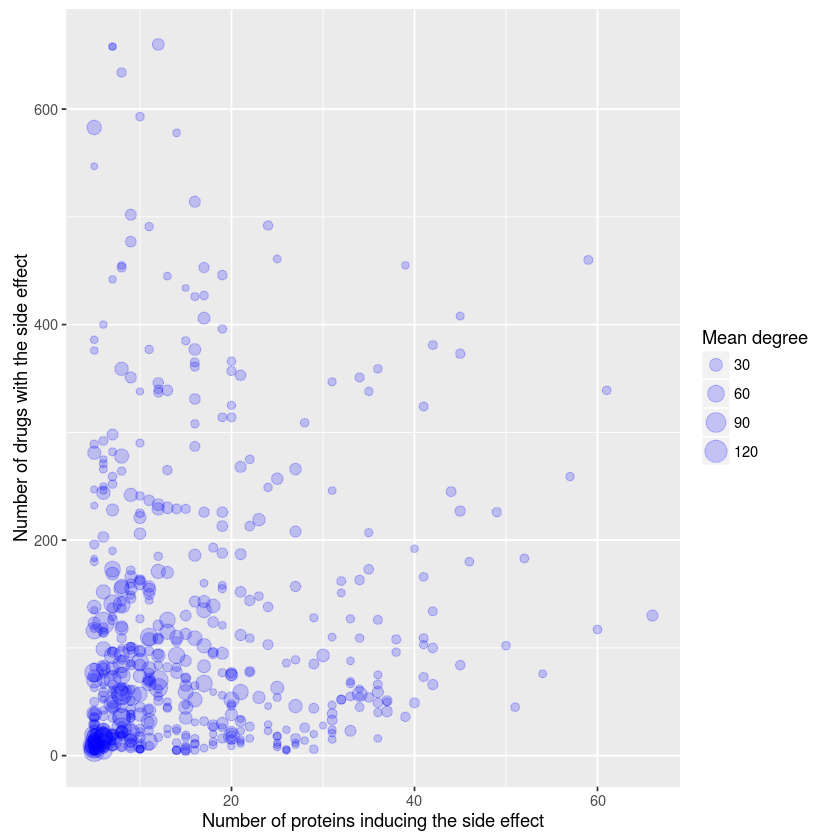

In [1]:
# Load required packages
require(ggplot2)
require(ROCR)
color.palette <- c("blue", "orange", "grey20", "red", "green", "yellow")

# Module scatter plot
base.dir = "./"
file.name = paste0(base.dir, "module.dat")
d = read.csv(file.name, sep="\t")
p = ggplot(data=d, aes(n.target, n.drug)) + geom_point(aes(size=k.target.mean), alpha=0.2, color="blue")
p = p + labs(x = "Number of proteins inducing the side effect", y = "Number of drugs with the side effect")
p = p + guides(size=guide_legend(title="Mean degree"))
print(p)

# Correlation between side effect proteins and number of drugs with the side effect
a = cor.test(d$n.target, d$n.drug, method="spearman")
print(a)

# Correlation between average degree of side effect proteins and number of drugs with the side effect
a = cor.test(d$k.target.mean, d$n.drug, method="spearman")                              
print(a)

# Degrees of side effect proteins in modules
summary(d$k.target.mean)

file.name = paste0(base.dir, "degree.dat")
d=read.csv(file.name, sep="\t")

# Average degree of network
summary(d$degree)

# Average degree of side effect proteins
x=d[d$flag==1,"degree"]
summary(x)

# Average degree of non-side effect proteins
y=d[d$flag==0,"degree"]
summary(y)

## ProXide validation

Precision, recall and F-score at various cutoffs. True positive drug-side effect associations are the ones known in SIDER. All the remaining associations are assumed to be negatives.

[1] "AUC: 0.711"


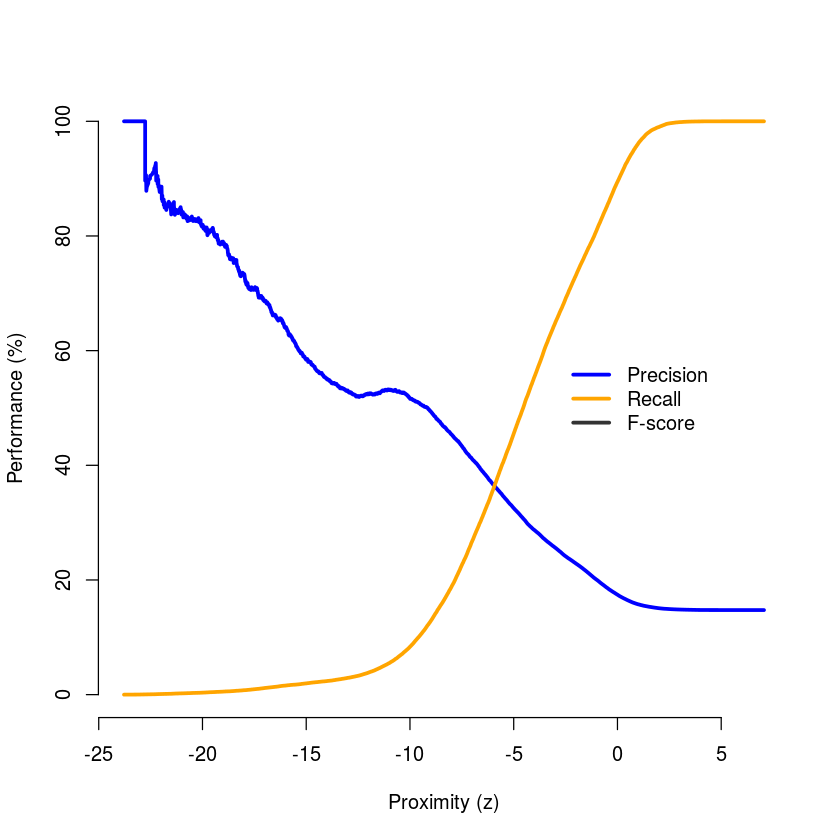

In [2]:
file.name = paste0(base.dir, "proximity.dat")
d = read.csv(file.name, sep="\t")
d = d[,c("flag", "z")]
d$z = -d$z # for performance calculation (lower z better)
pred = prediction(d$z, d$flag)

# Area under ROC curve
#perf = performance(pred, "tpr", "fpr")
#plot(perf)
perf = performance(pred, "auc")
print(sprintf("AUC: %.3f", perf@y.values[[1]]))
    
perf = performance(pred, "prec")
x = -perf@x.values[[1]]
a = 100*perf@y.values[[1]]
plot(x, a, col=color.palette[1], type="l", bty="n", lwd=3, xlab="Proximity (z)", ylab="Performance (%)", ylim=c(0,100))

perf = performance(pred, "sens")
b = 100*perf@y.values[[1]]
lines(x, b, col=color.palette[2], lwd=3)

y = 2*a*b / (a+b)
#lines(x, y, col=color.palette[3], lwd=4)
legend(-3, 60, legend=c("Precision", "Recall", "F-score"), col=color.palette[1:3], lty=c(1,1,1), lwd=c(3,3,3), bty="n") 


## ProXide versus similarity based approaches

AUROC and AUPRC values for ProXide, chemical similarity, target similarity, target interactome closeness similarity and ProXim (predictor combining ProXide with chemical and target similarity)

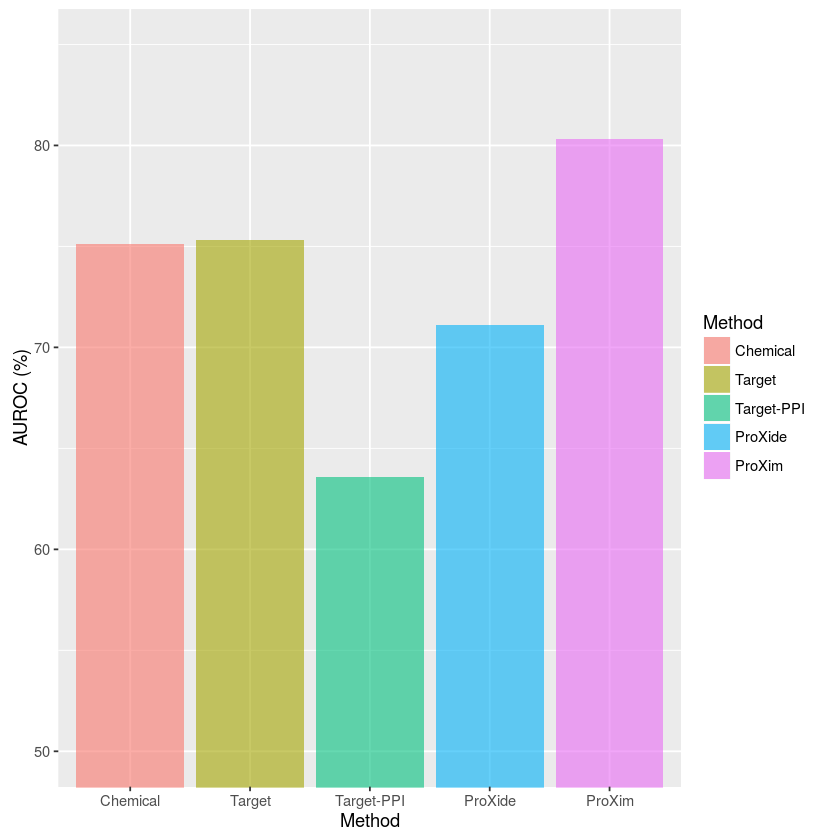

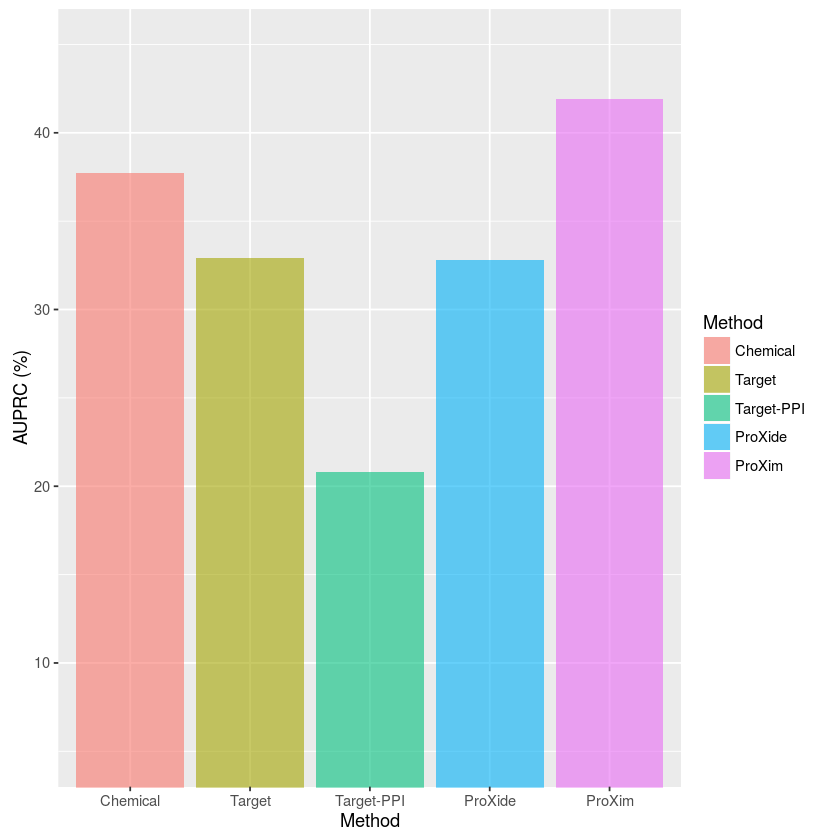

In [3]:
file.name = paste0(base.dir, "validation.dat")
d = read.csv(file.name, sep="\t")
d = cbind(d[,-(8:10)], apply(d[,8:10], 2, function(x){round(100*x, 1)}))
d$method = factor(d$method, levels=c("Chemical", "Target", "Target-PPI", "ProXide", "ProXim"))

#AUROC
e = d[d$cutoff.drug.se == 5 & d$cutoff.drug.target == 1 & d$cutoff.se.target == 5 & d$source == "sider",]
p = ggplot(data=e, aes(method, auc)) + geom_bar(aes(fill=method), stat="identity", position="dodge", alpha=0.6)
p = p + coord_cartesian(ylim = c(50, 85)) + guides(fill=guide_legend("Method"))
p = p + labs(x = "Method", y = "AUROC (%)")
print(p)

# AUPRC
p = ggplot(data=e, aes(method, auprc)) + geom_bar(aes(fill=method), stat="identity", position="dodge", alpha=0.6)
p = p + coord_cartesian(ylim = c(5, 45)) + guides(fill=guide_legend("Method"))
p = p + labs(x = "Method", y = "AUPRC (%)")
print(p)

## Assessing the effect of the data incompleteness

AUROC and AUPRC values when the analysis is repeated on a subset of drugs and side effects categorized based on the
number of targets drugs have (m) and number of proteins associated to the side effect (n).


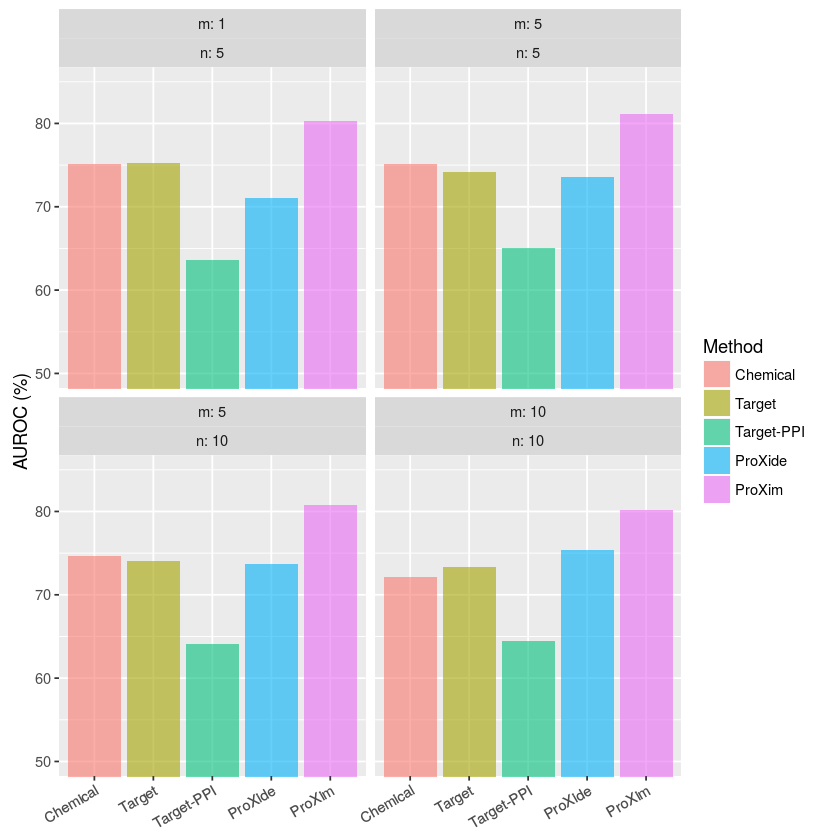

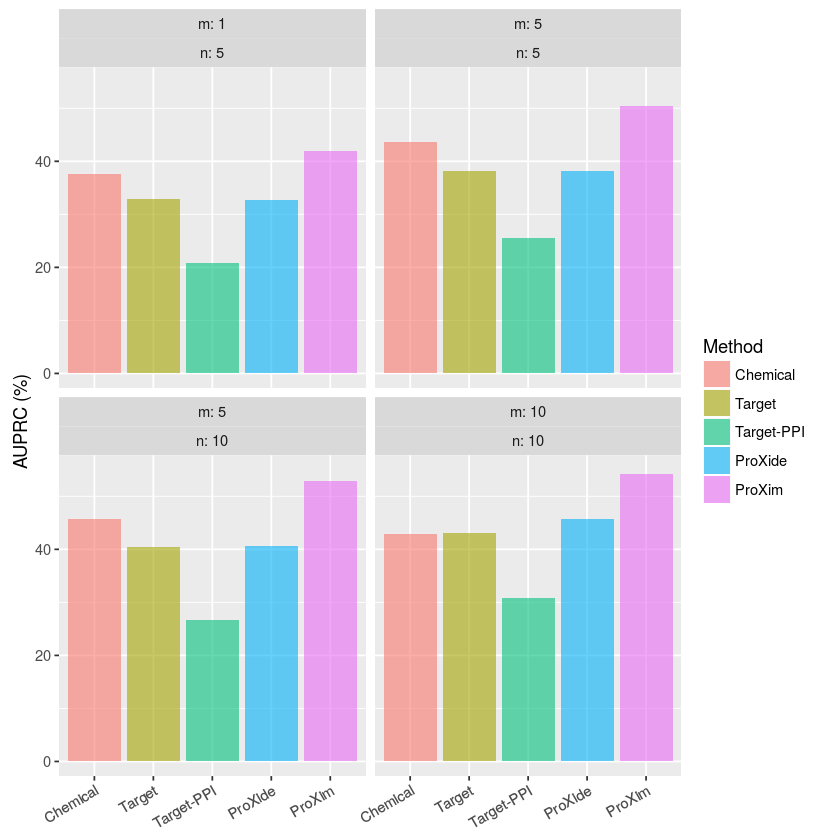

In [4]:
d$cutoff.drug.target = paste0("m: ", d$cutoff.drug.target)
d$cutoff.drug.target = factor(d$cutoff.drug.target, levels=c("m: 1", "m: 5", "m: 10"))
d$cutoff.se.target = paste0("n: ", d$cutoff.se.target)
d$cutoff.se.target = factor(d$cutoff.se.target, levels=c("n: 5", "n: 10"))
e = d[d$source=="sider" & d$cutoff.drug.se==5,]

#AUROC
p = ggplot(data=e, aes(method, auc)) + geom_bar(aes(fill=method), stat="identity", position="dodge", alpha=0.6)
p = p + coord_cartesian(ylim = c(50, 85)) + guides(fill=guide_legend("Method"))
p = p + labs(x = NULL, y = "AUROC (%)") + facet_wrap(~cutoff.drug.target + cutoff.se.target)
p = p + theme(axis.text.x = element_text(angle = 30, hjust = 1))
print(p)

# AUPRC
p = ggplot(data=e, aes(method, auprc)) + geom_bar(aes(fill=method), stat="identity", position="dodge", alpha=0.6)
p = p + coord_cartesian(ylim = c(0, 55)) + guides(fill=guide_legend("Method"))
p = p + labs(x = NULL, y = "AUPRC (%)") + facet_wrap(~cutoff.drug.target + cutoff.se.target)
p = p + theme(axis.text.x = element_text(angle = 30, hjust = 1))
print(p)
